SMS Data Set:
Feature variables:
1. SMS message
Target class: Message type
1. Ham, spam

In [1]:
!pip install nltk

import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


###  Creating Text Representations

Text data needs to be converted to numeric representations before they can be used to train deep learning models. The Spam classification feature data is converted to TF-IDF vectors and the target variable is converted to one-hot encoding.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Spam-Classification.csv to Spam-Classification.csv


In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

#Load Spam Data and review content
spam_data = pd.read_csv("Spam-Classification.csv")

print("\nLoaded Data :\n------------------------------------")
print(spam_data.head())

#Separate feature and target data
spam_classes_raw = spam_data["CLASS"]
spam_messages = spam_data["SMS"]



Loaded Data :
------------------------------------
  CLASS                                                SMS
0   ham   said kiss, kiss, i can't do the sound effects...
1   ham      &lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2  spam  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3  spam  * FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4  spam  **FREE MESSAGE**Thanks for using the Auction S...


In [5]:
import nltk
import tensorflow as tf

#Custom tokenizer to remove stopwords and use lemmatization
def customtokenize(str):
    #Split string as tokens
    tokens=nltk.word_tokenize(str)
    #Filter for stopwords
    nostop = list(filter(lambda token: token not in stopwords.words('english'), tokens))
    #Perform lemmatization
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Build a TF-IDF Vectorizer model
vectorizer = TfidfVectorizer(tokenizer=customtokenize)

In [7]:
#Transform feature input to TF-IDF
tfidf=vectorizer.fit_transform(spam_messages)
#Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
#Build a label encoder for target variable to convert strings to numeric values.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
spam_classes = label_encoder.fit_transform(
                                spam_classes_raw)


In [9]:
#Convert target to one-hot encoding vector
spam_classes = tf.keras.utils.to_categorical(spam_classes,2)

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", spam_classes.shape)

X_train,X_test,Y_train,Y_test = train_test_split( tfidf_array, spam_classes, test_size=0.10)

TF-IDF Matrix Shape :  (1500, 4566)
One-hot Encoding Shape :  (1500, 2)


###  Building and Evaluating the Model

In [10]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

#Setup Hyper Parameters for building the model
NB_CLASSES=2
N_HIDDEN=32

model = tf.keras.models.Sequential()

model.add(keras.layers.Dense(N_HIDDEN,
                             input_shape=(X_train.shape[1],),
                              name='Hidden-Layer-1',
                              activation='relu'))

model.add(keras.layers.Dense(N_HIDDEN,
                              name='Hidden-Layer-2',
                              activation='relu'))

model.add(keras.layers.Dense(NB_CLASSES,
                             name='Output-Layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 32)                146144    
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                1056      
                                                                 
 Output-Layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 147,266
Trainable params: 147,266
Non-trainable params: 0
_________________________________________________________________



Training Progress:
------------------------------------
Epoch 1/10
5/5 [==============================] - 3s 177ms/step - loss: 0.6911 - accuracy: 0.5972 - val_loss: 0.6849 - val_accuracy: 0.7259
Epoch 2/10
5/5 [==============================] - 0s 38ms/step - loss: 0.6763 - accuracy: 0.8435 - val_loss: 0.6670 - val_accuracy: 0.8704
Epoch 3/10
5/5 [==============================] - 0s 33ms/step - loss: 0.6501 - accuracy: 0.9306 - val_loss: 0.6412 - val_accuracy: 0.8741
Epoch 4/10
5/5 [==============================] - 0s 32ms/step - loss: 0.6145 - accuracy: 0.9546 - val_loss: 0.6090 - val_accuracy: 0.9037
Epoch 5/10
5/5 [==============================] - 0s 41ms/step - loss: 0.5727 - accuracy: 0.9611 - val_loss: 0.5756 - val_accuracy: 0.8889
Epoch 6/10
5/5 [==============================] - 0s 29ms/step - loss: 0.5284 - accuracy: 0.9630 - val_loss: 0.5380 - val_accuracy: 0.9222
Epoch 7/10
5/5 [==============================] - 0s 27ms/step - loss: 0.4820 - accuracy: 0.9704 - val_loss:

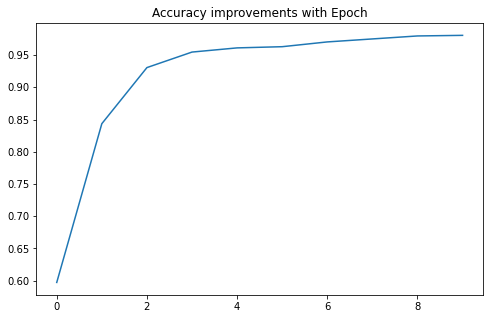


Evaluation against Test Dataset :
------------------------------------
5/5 [==============================] - 0s 10ms/step - loss: 0.3835 - accuracy: 0.9267


[0.38351795077323914, 0.9266666769981384]

In [11]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training
BATCH_SIZE=256
EPOCHS=10
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

history=model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

print("\nAccuracy during Training :\n------------------------------------")
import matplotlib.pyplot as plt

pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)

### Predicting for Text

In [14]:
#Predict for multiple samples using batch processing

#Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(["FREE gift card",
                                    "Yup I will come over"]).toarray()

print(predict_tfidf.shape)

#Predict using model
prediction=np.argmax( model.predict(predict_tfidf), axis=1 )
print("Prediction Output:" , prediction)

#Print prediction classes
print("Prediction Classes are ", label_encoder.inverse_transform(prediction))

(2, 4566)
1/1 [==============================] - 0s 189ms/step
Prediction Output: [1 0]
Prediction Classes are  ['spam' 'ham']
